# Objective: 
1. Tune parameters short_window and long_window to maximize profit
2. Learn signal generation
  

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML

In [5]:
class CROSSOVER:
    ## class attribute: We can know the possible values for moving_average and metrics 
    ## before creating an object of the class 
    moving_average = ("Simple","exponential") 
    metrics = {'Sharpe':'Sharpe Ratio',
               'CAGR':'Compound Average Growth Rate',
               'MDD':'Maximum Drawdown',
               'NHR':'Normalized Hit Ratio',
               'OTS':'Optimal trade size'}
    
    def __init__(self,data,short_window = 5, long_window = 40,
                 moving_average = "Simple", data_name = None, start = None,end = None ):

        """
         Doc string of the class. We define what class is about here
        """
        self.data=data #the dataframe
        self.data['yr'] = self.data['Date'].dt.year
        self.moving_average = moving_average
        if data_name is None:#the name that will appear on plots
            self.data_name = moving_average
        else:
            self.data_name=data_name
        self.short_window = short_window
        self.long_window = long_window
        self.n_days = (self.data.Date.iloc[-1] - self.data.Date.iloc[0])
        self.start=start #the beginning date of the sample period
        self.end=end #the ending date of the sample period

    def generate_signals(self, charts=True, burn=False):
        """
        This is an instance method. Only works on an object.
        """
        if self.long_window <= self.short_window: return

        if self.moving_average == "Simple":
            self.data["SMA"] = self.data.Close.rolling(self.short_window).mean()
            self.data["LMA"] = self.data.Close.rolling(self.long_window).mean()
        elif self.moving_average == "exponential":
            self.data["SMA"] = self.data.Close.ewm(span = self.short_window, adjust=True).mean()
            self.data["LMA"] = self.data.Close.ewm(span = self.long_window, adjust=True).mean()
        else:
            raise Exception("Not a valid type")

        self.data["_lag1_SMA"] = self.data.SMA.shift(1)
        self.data["_lag1_LMA"] = self.data.LMA.shift(1)

        ## creating signal    
        buy_mask = (self.data.SMA > self.data.LMA) & (self.data._lag1_SMA < self.data._lag1_LMA)
        sell_mask = (self.data.SMA < self.data.LMA) & (self.data._lag1_SMA > self.data._lag1_LMA)

        self.data['signal'] = np.nan
        self.data.loc[buy_mask,'signal'] = +1
        self.data.loc[sell_mask,'signal'] = -1
        if burn:
            burn_period = 2*self.long_window
            self.data.loc[:burn_period,"signal"] = np.nan
        self.data.signal = self.data.signal.fillna(method="ffill")

        mask = (self.data.signal != self.data.signal.shift(1)) & (self.data.signal.notnull())
        self.data['trade_num'] = np.where(mask,1,0).cumsum()

        ## display chart
        if charts:
            plt.plot(self.data['Date'],self.data['SMA'],color='black', label=f'SMA ={self.short_window}')
            plt.plot(self.data['Date'],self.data['LMA'],color='blue', label=f'LMA ={self.long_window}')
            plt.title('%s Strategy Backtest'%(self.data_name))
            plt.legend(loc=0)
            d_color = {}
            d_color[1] = '#90ee90'  ## light green
            d_color[-1] = "#ffcccb" ## light red

            j = 0
            for i in range(1,self.data.shape[0]):
                if np.isnan(self.data.signal[i-1]):
                    j=i
                elif (self.data.signal[i-1] == self.data.signal[i]) and (i< (self.data.shape[0]-1)):
                    continue
                else:
                    plt.axvspan(self.data['Date'][j], self.data['Date'][i], 
                               alpha=0.5, color=d_color[self.data.signal[i-1]], label="interval")
                    j = i
            plt.show()
        
    def signal_performance(self, allocation):
        """
        Another instance method
        """
        if self.long_window <= self.short_window: return
        self.allocation=allocation

        #creating returns and portfolio value series
        self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1))
        self.data['S_Return']=self.data['signal'].shift(1)*self.data['Return']
        self.data['Market_Return']=self.data['Return'].expanding().sum()
        self.data['Strategy_Return']=self.data['S_Return'].expanding().sum()
        self.data['Portfolio Value']=((self.data['Strategy_Return']+1)*self.allocation)
        self.data['Wins']=np.where(self.data['S_Return'] > 0,1,0)
        self.data['Losses']=np.where(self.data['S_Return']<0,1,0)

        ## Daywise Performance
        d_perform = {}
        d_perform['TotalWins']=self.data['Wins'].sum()
        d_perform['TotalLosses']=self.data['Losses'].sum()
        d_perform['TotalTrades']=d_perform['TotalWins']+d_perform['TotalLosses']
        d_perform['HitRatio']=round(d_perform['TotalWins']/d_perform['TotalTrades'],2)
        d_perform['SharpeRatio'] = self.data["S_Return"].mean() / self.data["S_Return"].std() * (252**.5)        
        d_perform['CAGR'] = (1+self.data['Strategy_Return']).iloc[-1]**(365.25/self.n_days.days) -1
        d_perform['MaxDrawdown']=(1.0-self.data['Portfolio Value']/self.data['Portfolio Value'].cummax()).max()
        self.daywise_performance = pd.Series(d_perform)

        ## Tradewise performance
        _df = self.data.groupby(["signal","trade_num"]).S_Return.sum().reset_index()
        _df['Wins']=np.where(_df['S_Return'] > 0,1,0)
        _df['Losses']=np.where(_df['S_Return']<0,1,0)
        d_tp = {}
        d_tp.update(_df[["Wins","Losses"]].sum().rename({'Wins':'TotalWins','Losses':'TotalLosses'}).to_dict())
        d_tp['TotalTrades'] = d_tp["TotalWins"] + d_tp["TotalLosses"]
        d_tp['HitRatio'] =  np.round(d_tp["TotalWins"] / d_tp['TotalTrades'],4)
        d_tp['AvgWinRet'] = np.round(_df[_df.Wins==1].S_Return.mean(),4)
        d_tp['AvgLossRet'] = np.round(_df[_df.Losses==1].S_Return.mean(),4)
        d_tp['WinByLossRet'] = np.round(abs(d_tp['AvgWinRet']/d_tp['AvgLossRet']),2)
        d_tp['RetVar'] = np.round(_df.S_Return.std(),4)
        _sum = _df.groupby("Wins").S_Return.sum()
        d_tp['NormHitRatio'] = np.round(_sum[1]/_sum.abs().sum(),4)
        d_tp['OptimalTradeSize'] = self.kelly(p = d_tp['HitRatio'], b = d_tp['WinByLossRet'])
        self.tradewise_performance = pd.Series(d_tp)

    @staticmethod
    def kelly(p,b):
        """
        Static method: No object or class related arguments
        p: win prob, b: net odds received on wager, output(f*) = p - (1-p)/b

        Spreadsheet example
            from sympy import symbols, solve, diff
            x = symbols('x')
            y = (1+3.3*x)**37 *(1-x)**63
            solve(diff(y, x), x)[1]
        Shortcut
            .37 - 0.63/3.3
        """
        return np.round(p - (1-p)/b,4)

    def plot_performance(self, allocation=1):
        #intializing a variable for initial allocation
        #to be used to create equity curve
        self.signal_performance(allocation)
        
        #yearly performance
        self.yearly_performance()
        
        #Plotting the Performance of the strategy
        plt.plot(self.data['Date'],self.data['Market_Return'],color='black', label='Market Returns')
        plt.plot(self.data['Date'],self.data['Strategy_Return'],color='blue', label= 'Strategy Returns')
        plt.title('%s Strategy Backtest'%(self.data_name))
        plt.legend(loc=0)
        plt.tight_layout()
        plt.show()

        plt.plot(self.data['Date'],self.data['Portfolio Value'], color='blue')
        plt.title('%s Portfolio Value'%(self.data_name))
        plt.show()
        
    def yearly_performance(self):
        """
        Instance method
        Adds an instance attribute: yearly_df
        """
        _yearly_df = self.data.groupby(['yr','signal']).S_Return.sum().unstack()
        _yearly_df.rename(columns={-1.0:'Sell',1.0:'Buy'}, inplace=True)
        _yearly_df['Return'] = _yearly_df.sum(1)

        # yearly_df
        self.yearly_df = _yearly_df.style.bar(color=["#ffcccb",'#90ee90'], align = 'zero').format({
            'Sell': '{:,.2%}'.format,'Buy': '{:,.2%}'.format,'Return': '{:,.2%}'.format})
    
    def update_metrics(self):
        """
        Called from the SMA_LMA_matrix class method
        """
        d_field = {}
        if self.long_window > self.short_window:
            d_field['Sharpe'] = self.daywise_performance.SharpeRatio
            d_field['CAGR'] = self.daywise_performance.CAGR
            d_field['MDD'] = self.daywise_performance.MaxDrawdown
            d_field['NHR'] = self.tradewise_performance.NormHitRatio
            d_field['OTS'] = self.tradewise_performance.OptimalTradeSize
            
        return d_field
    
    @classmethod
    def SMA_LMA_matrix(cls,data, LMA_range, SMA_range, metrics, moving_average = "Simple", optimal_sol = True):
        """
        This is a class method. First argument is a class.
        """
        c_green = sns.light_palette("green", as_cmap=True)
        c_red = sns.light_palette("red", as_cmap=True)
        
        d_mats = {m:[] for m in metrics}
        
        for l in LMA_range:
            d_row = {m:[] for m in metrics}
            for s in SMA_range:
                obj = cls(data, s, l, moving_average) ## object being created from the class
                obj.generate_signals(charts=False)
                obj.signal_performance(100)
                d_field = obj.update_metrics()
                for m in metrics: d_row[m].append(d_field.get(m,np.nan))
            for m in metrics: d_mats[m].append(d_row[m])
                
        d_df = {m:pd.DataFrame(d_mats[m], index=LMA_range, columns=SMA_range) for m in metrics}

        def optimal(_df):
            """ 
            This is a function inside a function.
            We could have created it outside the class if needed, but that would made it harder to relate. 
            """
            _df = _df.stack().rank()
            _df = (_df - _df.mean())/_df.std()
            return _df.unstack()

        if optimal_sol:
            d_df['Signal'] = 0
            if 'Sharpe' in metrics: d_df['Signal'] += 2*optimal(d_df['Sharpe'])
            if 'NHR' in metrics: d_df['Signal'] += optimal(d_df['NHR'])
            if 'CAGR' in metrics: d_df['Signal'] += optimal(d_df['CAGR'])
            if 'MDD' in metrics: d_df['Signal'] -= 2*optimal(d_df['MDD'])
            l_i,s_i = np.unravel_index(np.argmax(d_df['Signal'].values), d_df['Signal'].shape)
            print(f"Most optimal cross-over pair is SMA:{SMA_range[s_i]}, LMA:{LMA_range[l_i]}")
            metrics.insert(0,'Signal')

        for m in metrics:
            display(HTML(d_df[m].style.background_gradient(axis=None, cmap=
                c_red if m=="MDD" else c_green).format(
                ("{:,.2}" if m in ["Sharpe","Signal"] else "{:.2%}")).set_caption(m).render()))
            
        return d_df

In [6]:
close_df = pd.read_csv("class_data.csv", parse_dates = [0])

In [22]:
close_df.head()

,Date,Close,yr,SMA,LMA,_lag1_SMA,_lag1_LMA,signal,trade_num
0,2000-01-03,1592.2,2000,1592.200000,1592.200000,NaN,NaN,NaN,0
1,2000-01-04,1638.7,2000,1617.000000,1616.380000,1592.200000,1592.200000,NaN,0
2,2000-01-05,1595.8,2000,1608.971598,1608.964179,1617.000000,1616.380000,NaN,0
3,2000-01-06,1617.6,2000,1611.577935,1611.388831,1608.971598,1608.964179,NaN,0
4,2000-01-07,1613.3,2000,1612.019861,1611.834564,1611.577935,1611.388831,NaN,0


In [29]:
close_df.Close.ewm(span = 20, adjust=False, min_periods=20).mean()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11              NaN
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19      1600.876474
20      1595.983476
21      1595.223145
22      1595.478084
23      1595.884933
24      1599.762558
25      1605.761362
26      1613.750756
27      1623.031637
28      1635.695290
29      1646.057644
           ...     
4205    8353.729585
4206    8320.260101
4207    8292.930568
4208    8261.746704
4209    8247.704161
4210    8236.199003
4211    8227.241955
4212    8226.980816
4213    8223.735024
4214    8210.693593
4215    8202.889442
4216    8197.199971
4217    8188.138069
4218    8193.729681
4219    8200.207807
4220    8197.407063
4221    8199.730200
4222    8198.084467
4223    8193.847851


In [ ]:
self.data.Close.ewm(span = self.short_window, adjust=True).mean()

In [7]:
CROSSOVER.metrics

{'Sharpe': 'Sharpe Ratio',
 'CAGR': 'Compound Average Growth Rate',
 'MDD': 'Maximum Drawdown',
 'NHR': 'Normalized Hit Ratio',
 'OTS': 'Optimal trade size'}

In [8]:
CROSSOVER.moving_average

('Simple', 'exponential')

In [9]:
## Possible values for metrics : 'Sharpe','CAGR','MDD','NHR','OTS'
# _ = CROSSOVER.SMA_LMA_matrix(close_df, SMA_range=range(5,21), LMA_range=range(25,90,5),
#                     metrics = ['Sharpe','MDD','OTS'], moving_average='exponential')

In [19]:
ema_strategy = CROSSOVER(close_df, moving_average='exponential', short_window = 15, long_window = 25)

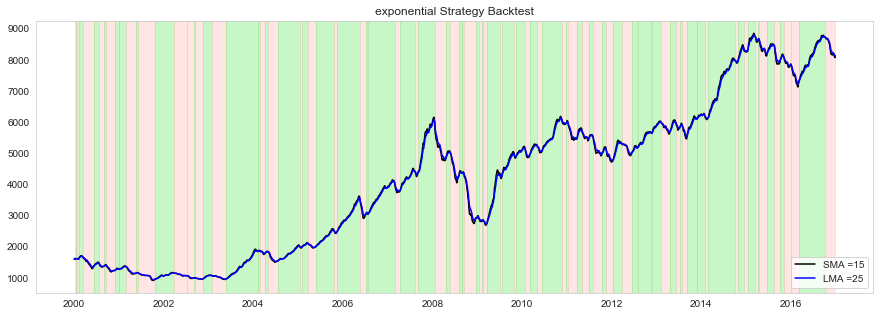

In [20]:
ema_strategy.generate_signals()

In [21]:
ema_strategy.data

,Date,Close,yr,SMA,LMA,_lag1_SMA,_lag1_LMA,signal,trade_num
0,2000-01-03,1592.20,2000,1592.200000,1592.200000,NaN,NaN,NaN,0
1,2000-01-04,1638.70,2000,1617.000000,1616.380000,1592.200000,1592.200000,NaN,0
2,2000-01-05,1595.80,2000,1608.971598,1608.964179,1617.000000,1616.380000,NaN,0
3,2000-01-06,1617.60,2000,1611.577935,1611.388831,1608.971598,1608.964179,NaN,0
4,2000-01-07,1613.30,2000,1612.019861,1611.834564,1611.577935,1611.388831,NaN,0
5,2000-01-10,1632.95,2000,1616.766314,1616.093531,1612.019861,1611.834564,NaN,0
6,2000-01-11,1572.50,2000,1607.655081,1608.276169,1616.766314,1616.093531,-1.0,1
7,2000-01-12,1624.80,2000,1610.920078,1610.964046,1607.655081,1608.276169,-1.0,1
8,2000-01-13,1621.40,2000,1612.793253,1612.527566,1610.920078,1610.964046,1.0,2
9,2000-01-14,1622.75,2000,1614.482155,1613.955038,1612.793253,1612.527566,1.0,2


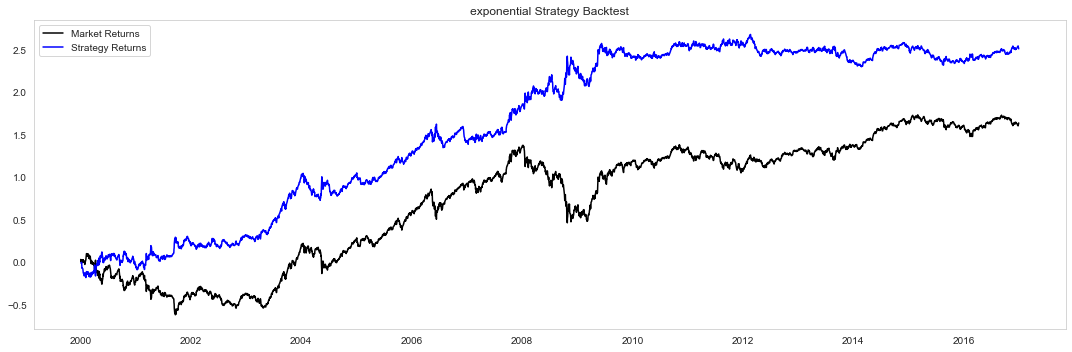

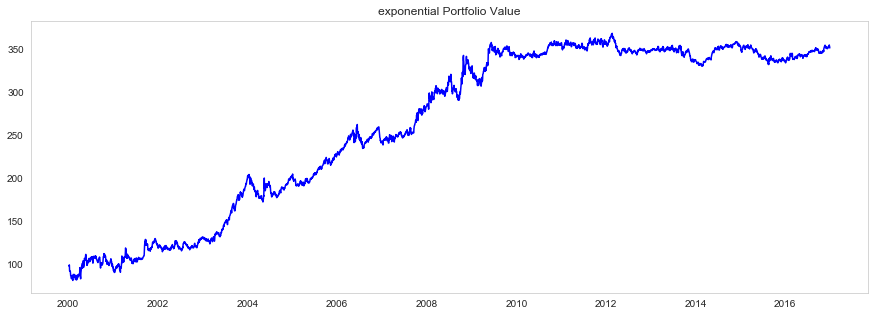

In [12]:
ema_strategy.plot_performance(100)

In [13]:
ema_strategy.daywise_performance

TotalWins      2197.000000
TotalLosses    2030.000000
TotalTrades    4227.000000
HitRatio          0.520000
SharpeRatio       0.623505
CAGR              0.076700
MaxDrawdown       0.194191
dtype: float64

In [14]:
ema_strategy.tradewise_performance

TotalWins            66.0000
TotalLosses         110.0000
TotalTrades         176.0000
HitRatio              0.3750
AvgWinRet             0.0775
AvgLossRet           -0.0237
WinByLossRet          3.2700
RetVar                0.0859
NormHitRatio          0.6625
OptimalTradeSize      0.1839
dtype: float64

In [15]:
ema_strategy.yearly_df

signal,Sell,Buy,Return
yr,,,
2000,5.89%,-9.57%,-3.68%
2001,19.09%,4.78%,23.88%
2002,8.09%,2.92%,11.01%
2003,5.51%,62.33%,67.84%
2004,-7.99%,12.16%,4.18%
2005,-3.84%,28.44%,24.60%
2006,-12.12%,25.85%,13.73%
2007,-0.05%,42.28%,42.23%
2008,67.22%,-26.02%,41.20%
